In [24]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score
from sklearn.multioutput import MultiOutputClassifier
from skmultilearn.model_selection import iterative_train_test_split

from gensim.utils import simple_preprocess
from gensim.models import Word2Vec
import gensim.downloader as api

import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer



In [12]:
df = pd.read_csv("mLabel_tweets.csv")  
df.head()


,ID,tweet,labels
0,1296010336907038720t,@cath__kath AstraZeneca is made with the kidne...,ingredients
1,1336808189677940736t,It begins. Please find safe alternatives to th...,side-effect
2,1329488407307956231t,"@PaolaQP1231 Well, I mean congratulations Covi...",side-effect
3,1364194604459900934t,@BorisJohnson for those of us that do not wish...,mandatory
4,1375938799247765515t,She has been trying to speak out: writing lett...,side-effect rushed


In [13]:
df = df[['tweet', 'labels']].dropna()

df['labels'] = df['labels'].apply(lambda x: x.split(','))


In [4]:
mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(df['labels'])
LABELS = mlb.classes_


X = df['tweet'].astype(str).tolist()

print("Shape:", df.shape)
print("Labels:", LABELS)


Shape: (9921, 2)
Labels: ['conspiracy' 'conspiracy country' 'conspiracy country ingredients'
 'conspiracy country pharma' 'conspiracy country side-effect'
 'conspiracy ineffective' 'conspiracy ineffective ingredients'
 'conspiracy ineffective side-effect' 'conspiracy ingredients'
 'conspiracy ingredients mandatory' 'conspiracy ingredients pharma'
 'conspiracy ingredients religious' 'conspiracy ingredients side-effect'
 'conspiracy mandatory' 'conspiracy mandatory political'
 'conspiracy mandatory side-effect' 'conspiracy pharma'
 'conspiracy pharma ingredients' 'conspiracy pharma political'
 'conspiracy pharma rushed' 'conspiracy pharma unnecessary'
 'conspiracy political' 'conspiracy political ingredients'
 'conspiracy political pharma' 'conspiracy religious' 'conspiracy rushed'
 'conspiracy rushed side-effect' 'conspiracy side-effect'
 'conspiracy side-effect ingredients' 'conspiracy side-effect rushed'
 'conspiracy unnecessary' 'conspiracy unnecessary ingredients' 'country'
 'countr

In [14]:
tokens = [simple_preprocess(doc) for doc in X]

In [15]:
w2v_model = Word2Vec(
    sentences=tokens,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4
)
vocab = set(w2v_model.wv.index_to_key)

In [16]:
def word2vec_embedding(doc):
    vectors = [w2v_model.wv[word] for word in doc if word in vocab]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)

X_w2v = np.array([word2vec_embedding(doc) for doc in tokens])
print("Word2Vec embedding shape:", X_w2v.shape)


Word2Vec embedding shape: (9921, 100)


In [17]:
glove = api.load("glove-wiki-gigaword-100")
dim = glove.vector_size

def glove_embedding(doc):
    vectors = [glove[word] for word in doc if word in glove]
    return np.mean(vectors, axis=0) if vectors else np.zeros(dim)

X_glove = np.array([glove_embedding(doc) for doc in tokens])
print("GloVe embedding shape:", X_glove.shape)


GloVe embedding shape: (9921, 100)


In [18]:
Y = np.array(Y)
valid_label_mask = Y.sum(axis=0) >= 2
Y = Y[:, valid_label_mask]
LABELS = LABELS[valid_label_mask]

print("Valid labels count:", len(LABELS))

Valid labels count: 157


Note: you may need to restart the kernel to use updated packages.


In [25]:
X_emb = X_w2v 

X_emb = np.array(X_emb) 

X_train, y_train, X_test, y_test = iterative_train_test_split(
    X_emb, Y, test_size=0.2
)

print("Train size:", X_train.shape, y_train.shape)
print("Test size:", X_test.shape, y_test.shape)


Train size: (7936, 100) (7936, 157)
Test size: (1985, 100) (1985, 157)


# LogisticRegression with MultiOutputClassifier.

In [26]:
def evaluate_model(X_train, y_train, X_test, y_test, labels, name):
    model = MultiOutputClassifier(LogisticRegression(max_iter=2000))
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"\n{name} – Classification Report\n")
    print(classification_report(
        y_test,
        y_pred,
        target_names=labels,
        zero_division=0
    ))
    
    micro = f1_score(y_test, y_pred, average="micro", zero_division=0)
    macro = f1_score(y_test, y_pred, average="macro", zero_division=0)
    
    return {"Model": name, "Micro F1": micro, "Macro F1": macro}

results = []
results.append(evaluate_model(X_train, y_train, X_test, y_test, LABELS, "Word2Vec"))
results.append(evaluate_model(X_train, y_train, X_test, y_test, LABELS, "GloVe"))  # Optional, use X_glove



Word2Vec – Classification Report

                                     precision    recall  f1-score   support

                         conspiracy       0.00      0.00      0.00        29
                 conspiracy country       0.00      0.00      0.00         1
             conspiracy ineffective       0.00      0.00      0.00         1
 conspiracy ineffective side-effect       0.00      0.00      0.00         0
             conspiracy ingredients       0.00      0.00      0.00         7
   conspiracy ingredients religious       0.00      0.00      0.00         0
 conspiracy ingredients side-effect       0.00      0.00      0.00         1
               conspiracy mandatory       0.00      0.00      0.00         1
                  conspiracy pharma       0.00      0.00      0.00        11
      conspiracy pharma ingredients       0.00      0.00      0.00         1
        conspiracy pharma political       0.00      0.00      0.00         0
      conspiracy pharma unnecessary     


GloVe – Classification Report

                                     precision    recall  f1-score   support

                         conspiracy       0.00      0.00      0.00        29
                 conspiracy country       0.00      0.00      0.00         1
             conspiracy ineffective       0.00      0.00      0.00         1
 conspiracy ineffective side-effect       0.00      0.00      0.00         0
             conspiracy ingredients       0.00      0.00      0.00         7
   conspiracy ingredients religious       0.00      0.00      0.00         0
 conspiracy ingredients side-effect       0.00      0.00      0.00         1
               conspiracy mandatory       0.00      0.00      0.00         1
                  conspiracy pharma       0.00      0.00      0.00        11
      conspiracy pharma ingredients       0.00      0.00      0.00         1
        conspiracy pharma political       0.00      0.00      0.00         0
      conspiracy pharma unnecessary       0

In [27]:
results_df = pd.DataFrame(results)
print("\nPerformance Comparison:\n", results_df)



Performance Comparison:
       Model  Micro F1  Macro F1
0  Word2Vec  0.268376  0.005045
1     GloVe  0.268376  0.005045


In [28]:
models = results_df["Model"].tolist()
micro_scores = results_df["Micro F1"].tolist()
macro_scores = results_df["Macro F1"].tolist()

x = np.arange(len(models))
width = 0.35


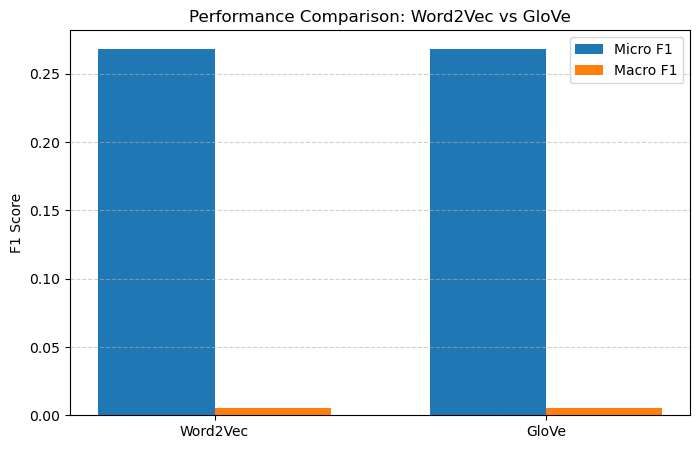

In [29]:
plt.figure(figsize=(8, 5))
plt.bar(x - width/2, micro_scores, width, label="Micro F1")
plt.bar(x + width/2, macro_scores, width, label="Macro F1")
plt.xticks(x, models)
plt.ylabel("F1 Score")
plt.title("Performance Comparison: Word2Vec vs GloVe")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

# RandomForestClassifier inside MultiOutputClassifier.

In [30]:
X_combined = np.concatenate([X_w2v, X_glove], axis=1)
print("Combined embedding shape:", X_combined.shape)

Combined embedding shape: (9921, 200)


In [34]:
valid_label_mask = Y.sum(axis=0) >= 2
Y = Y[:, valid_label_mask]
LABELS = LABELS[valid_label_mask]

print("Number of labels after cleaning:", len(LABELS))


Number of labels after cleaning: 157


In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, Y, test_size=0.2, random_state=42
)

print("Train size:", X_train.shape, y_train.shape)
print("Test size:", X_test.shape, y_test.shape)


Train size: (7936, 200) (7936, 157)
Test size: (1985, 200) (1985, 157)


In [36]:
def evaluate_model(X_train, y_train, X_test, y_test, labels, name):
    model = MultiOutputClassifier(
        RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"\n{name} – Classification Report\n")
    print(classification_report(
        y_test,
        y_pred,
        target_names=labels,
        zero_division=0
    ))
    
    micro = f1_score(y_test, y_pred, average="micro", zero_division=0)
    macro = f1_score(y_test, y_pred, average="macro", zero_division=0)
    
    return {"Model": name, "Micro F1": micro, "Macro F1": macro}

results = []
results.append(evaluate_model(X_train, y_train, X_test, y_test, LABELS, "Word2Vec + GloVe + RF"))



Word2Vec + GloVe + RF – Classification Report

                                     precision    recall  f1-score   support

                         conspiracy       0.00      0.00      0.00        27
                 conspiracy country       0.00      0.00      0.00         0
             conspiracy ineffective       0.00      0.00      0.00         0
 conspiracy ineffective side-effect       0.00      0.00      0.00         0
             conspiracy ingredients       0.00      0.00      0.00        13
   conspiracy ingredients religious       0.00      0.00      0.00         1
 conspiracy ingredients side-effect       0.00      0.00      0.00         1
               conspiracy mandatory       0.00      0.00      0.00         1
                  conspiracy pharma       1.00      0.09      0.17        11
      conspiracy pharma ingredients       0.00      0.00      0.00         0
        conspiracy pharma political       0.00      0.00      0.00         0
      conspiracy pharma unn

In [38]:
results_df = pd.DataFrame(results)
models = results_df["Model"].tolist()
micro_scores = results_df["Micro F1"].tolist()
macro_scores = results_df["Macro F1"].tolist()


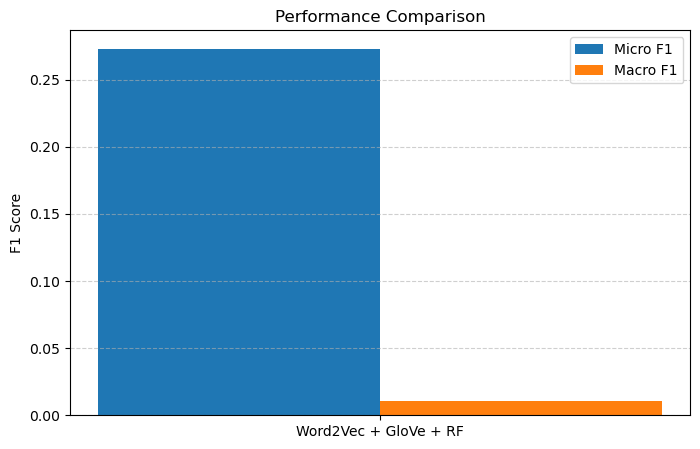

In [39]:
x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, micro_scores, width, label="Micro F1")
plt.bar(x + width/2, macro_scores, width, label="Macro F1")
plt.xticks(x, models)
plt.ylabel("F1 Score")
plt.title("Performance Comparison")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()